# X-ray image loading and analysis

With this notebook, we will use convolutional neural networks (CNN) to analyze our X-rays of each patient and generate predictions on their mortality outcomes. The outline for this notebook is as follows:

<br>1) Load Packages
<br>2) Load images with Image Data Generator
<br>3) Examine select images and their shapes
<br>4) Perform Train Test split to generate train, test, and validation sets. Defining functions
<br>5) Generation of dummy and CNN models, model evaluation plots and metrics
<br>6) Predictions of final model, generation of dataframe with final model predictions

## 1) LOADING PACKAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier


from tensorflow.keras.layers import Input
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping

## 2) Now that the files have been moved to their respective labels, we can use the image generator to begin modeling analysis

In [2]:
data_dir = 'Classes'


#create test generator for final model evaluation(20% of entire dataset)
data_generator = ImageDataGenerator(1./255).flow_from_directory(
       data_dir, 
       target_size=(128, 128), batch_size=6700, color_mode='grayscale', class_mode='binary', shuffle=False)

# #create train generator for model training and validation(80% of dataset). Will create validation split with TTS from train set
# train_generator = ImageDataGenerator(1./255).flow_from_directory(
#        data_dir, 
#        target_size=(128, 128), batch_size=5360, color_mode='grayscale', class_mode='binary').

#Create the datasets
data_images, data_labels = next(data_generator)
# test_images, test_labels = next(test_generator)

Found 6700 images belonging to 2 classes.


C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


## 3) Examination of select image,  data set shapes, and labels

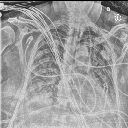

In [3]:
#sample photo
array_to_img(data_images[0])

In [4]:
#labels
data_generator.class_indices

{'deceased': 0, 'discharged': 1}

#### checking image and label shapes for model creation

In [5]:
data_images.shape

(6700, 128, 128, 1)

In [6]:
data_labels.shape

(6700,)

## 4) Creating train, test, and validation data from TTS in order to train CNN models

In [7]:
#train test split to generate training and test data

X = data_images
y = data_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#creating 2nd train and validation set from initial training set

x = X_train
Y = y_train

X_train2, X_val, y_train2, y_val = train_test_split(x, Y, test_size=0.2, random_state=42)

In [9]:
#investigating shapes of train and validation sets
print(np.shape(X_train2))
print(np.shape(X_val))
print(np.shape(y_train2))
print(np.shape(y_val))

(4288, 128, 128, 1)
(1072, 128, 128, 1)
(4288,)
(1072,)


### 4a) Defining functions

In [10]:
#function to plot epochs vs loss and accuracy for train and validation/test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['test_loss', 'train_loss'])
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['test_acc', 'train_acc'])
    plt.title('Epochs vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

In [11]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    
    return sns.heatmap(matrix, annot=True, cmap='BuPu', fmt='.4g', xticklabels=['Deceased', 'Discharged'], 
                       yticklabels=['Deceased', 'Discharged']), plt.yticks(rotation=0)

## 5) Generation of dummy and all CNN models

### Baseline dummy classifier

In [14]:
#dummy classifier to compare baseline models to


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train2, y_train2)
dummy.predict(X_val)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [15]:
#dummy classifier score
dummy.score(X_val, y_val)

0.5998134328358209

### To start, a simple CNN model will be used with no dropouts or multiple dense layers.

In [16]:
#baseline CNN model
np.random.seed(424)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8128576   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,128,961
Trainable params: 8,128,961
Non-trainable params: 0
_________________________________________________________________


### Accuracy will be the primary metric of evaluation. A low learning rate is used to improve model learning. SGD is the preferred optimizer; previous iterations with Adam yielded lower accuracy rates.

In [18]:
#compile and fit the training data, then validate the fit with validation data
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
optimizer = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results = model.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 17s 503ms/step - loss: 22.7923 - acc: 0.5679 - val_loss: 0.6868 - val_acc: 0.5942
Epoch 2/50
34/34 [==============================] - 15s 450ms/step - loss: 0.6769 - acc: 0.5940 - val_loss: 0.6826 - val_acc: 0.6082
Epoch 3/50
34/34 [==============================] - 15s 449ms/step - loss: 0.6664 - acc: 0.6042 - val_loss: 0.6809 - val_acc: 0.6194
Epoch 4/50
34/34 [==============================] - 15s 448ms/step - loss: 0.6572 - acc: 0.6082 - val_loss: 0.6795 - val_acc: 0.6185
Epoch 5/50
34/34 [==============================] - 15s 449ms/step - loss: 0.6496 - acc: 0.6189 - val_loss: 0.6769 - val_acc: 0.6231
Epoch 6/50
34/34 [==============================] - 15s 447ms/step - loss: 0.6425 - acc: 0.6271 - val_loss: 0.6757 - val_acc: 0.6203
Epoch 7/50
34/34 [==============================] - 15s 446ms/step - loss: 0.6358 - acc: 0.6381 - val_loss: 0.6737 - val_acc: 0.6203
Epoch 8/50
34/34 [==============================] - 15s 448ms/step -

#### Model results with train and validation sets

In [19]:
results_train = model.evaluate(X_train2, y_train2)

134/134 [==============================] - 5s 38ms/step - loss: 0.4972 - acc: 0.7535


In [20]:
results_val = model.evaluate(X_val, y_val)

34/34 [==============================] - 1s 36ms/step - loss: 0.6777 - acc: 0.6157


#### Visualizing results

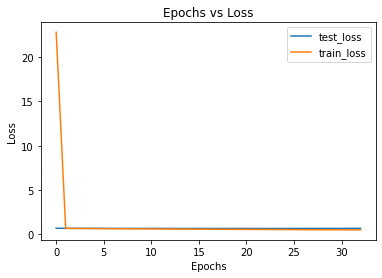

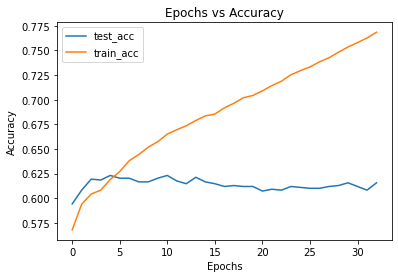

In [21]:
visualize_results(results)

(<AxesSubplot:>,
 (array([0.5, 1.5]), [Text(0, 0.5, 'Deceased'), Text(0, 1.5, 'Discharged')]))

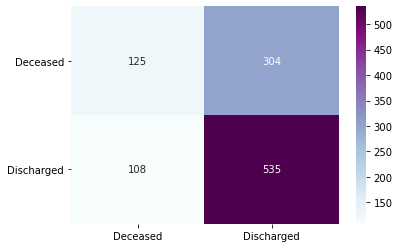

In [22]:
#confusion matrix for model predictions

label_pred = (model.predict(X_val) > 0.5).astype(int)

plot_matrix(y_val, label_pred);



### Insight: This model appears to begin overfitting to the training data, and the validation accuracy does not increase. Will adding addtional convolution layers increase performance?

In [23]:
# Increasing convolutional layers
np.random.seed(424)
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (2, 2), activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))

model2.add(layers.Flatten())
model2.add(layers.Dense(96, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        4160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

In [25]:
optimizer = keras.optimizers.SGD(lr=0.00001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results2 = model2.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 31s 899ms/step - loss: 2.0524 - acc: 0.5466 - val_loss: 1.4119 - val_acc: 0.5280
Epoch 2/50
34/34 [==============================] - 31s 909ms/step - loss: 1.5119 - acc: 0.5308 - val_loss: 1.3927 - val_acc: 0.5233
Epoch 3/50
34/34 [==============================] - 31s 912ms/step - loss: 1.5060 - acc: 0.5285 - val_loss: 1.3400 - val_acc: 0.5261
Epoch 4/50
34/34 [==============================] - 30s 894ms/step - loss: 1.4670 - acc: 0.5343 - val_loss: 1.3082 - val_acc: 0.5243
Epoch 5/50
34/34 [==============================] - 30s 894ms/step - loss: 1.4345 - acc: 0.5361 - val_loss: 1.2730 - val_acc: 0.5326
Epoch 6/50
34/34 [==============================] - 30s 893ms/step - loss: 1.4005 - acc: 0.5359 - val_loss: 1.2486 - val_acc: 0.5364
Epoch 7/50
34/34 [==============================] - 30s 893ms/step - loss: 1.3757 - acc: 0.5375 - val_loss: 1.2329 - val_acc: 0.5382
Epoch 8/50
34/34 [==============================] - 31s 899ms/step - 

#### Model2 predictions and visualizing results

In [26]:
results_train2 = model2.evaluate(X_train2, y_train2)

134/134 [==============================] - 7s 53ms/step - loss: 0.9064 - acc: 0.5800


In [27]:
results_test2 = model2.evaluate(X_val, y_val)

34/34 [==============================] - 2s 51ms/step - loss: 0.9764 - acc: 0.5737


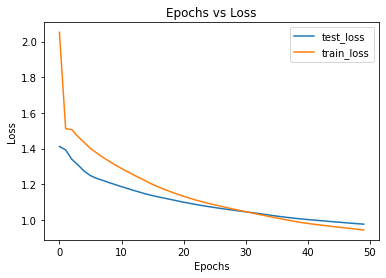

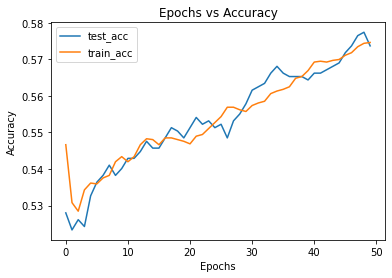

In [28]:
# train_pred = (model2.predict(X_train2) > 0.5).astype(int)
val_pred = (model2.predict(X_val) > 0.5).astype(int)

visualize_results(results2)

(<AxesSubplot:>,
 (array([0.5, 1.5]), [Text(0, 0.5, 'Deceased'), Text(0, 1.5, 'Discharged')]))

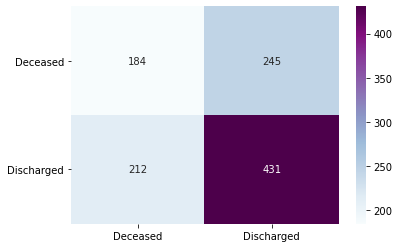

In [29]:
plot_matrix(y_val, val_pred);


### While the 2nd model resolves the overfitting issue, the accuracy has decreased for both training and validation sets. Will regularization improve accuracy scores for better predictions? 

In [12]:
#adding regularization penalty to model

model3 = models.Sequential()
model3.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(96, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 96)        110688    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        55360     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        3

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.0001)
early_stopping2 = [EarlyStopping(monitor='val_loss', patience=10)]
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results3 = model3.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/25
67/67 [==============================] - 113s 2s/step - loss: 2.1942 - acc: 0.5518 - val_loss: 1.9601 - val_acc: 0.5765
Epoch 2/25
45/67 [===================>..........] - ETA: 34s - loss: 1.9655 - acc: 0.5771

#### Visualizing results for model 3

In [ ]:
results_train3 = model3.evaluate(X_train2, y_train2)

In [ ]:
results_test3 = model3.evaluate(X_val, y_val)

In [ ]:
visualize_results(results3)

In [ ]:
val_pred3 = (model3.predict(X_val) > 0.5).astype(int)
plot_matrix(y_val, val_pred3);


### Insight: Model 3 performed the best out of all the models. It doesn't overfit like model 1, and has better metrics than model 2 for both train and validation sets. Model 3 will be used to generate probability predictions for the entire dataset after being trained against the entire training set and validated with the testing set.

## 6) Final model predictions and prediction dataframe creation

In [ ]:
#fit against entire train set and validate with test set, then generate predictions
np.random.seed(42)
model3 = models.Sequential()
model3.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(96, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.0001)
early_stopping2 = [EarlyStopping(monitor='val_loss', patience=10)]
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results_final = model3.fit(X_train,
                    y_train,
                    callbacks=early_stopping2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_test, y_test), shuffle=False)

### Final model visualizations and evaluation

In [ ]:
train_final = model3.evaluate(X_train, y_train)

In [ ]:
test_final = model3.evaluate(X_test, y_test)

In [ ]:
visualize_results(results_final)

In [ ]:

final_pred = (model3.predict(X_test) > 0.5).astype(int)
plot_matrix(y_test, final_pred);


In [ ]:
#generate model predictions
data_pred = model3.predict(data_images)
data_pred

In [ ]:
#correlate predictions to patient IDs and convert to pandas dataframe

preds = data_pred.tolist()
pred_df = pd.DataFrame({'patient_id':data_generator.filenames, 'prediction':pred})
pred_df.head(-10)

In [83]:
#save predictions as a dataframe  
# import os
# cwd = os.getcwd()
# path = cwd + "/pred_df.csv"
# pred_df.to_csv(path, index=False)

## Summary: 
Model 3 offered the best overall structure of the tested CNN models. It did not overfit to the testing data and we can predict the likelihood of survival for each patient. It should be noted that since all the images trained and tested against the model are of COVID19+ patients. Without advanced image processing techniques, the similarity of images to one another adds a layer of difficulty for the model to deal with. 

By increasing computing power, using object detection to account for port presence, and more time to experiment with models, a higher performing model could be created to generate more accurate mortality predictions. The predictions generated by this model will be correlated to the patient IDs in the cleaned features dataframe (df), and used as an additional feature to help predict patient mortality outcomes. 